In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path

from pyuoi.linear_model import UoI_Lasso

In [2]:
import itertools, scipy, risk

### Consider a paired down, 10 feature linear regression problem. There is an optimal "correct" model living in a particular 4 feature subspace of the full parameter space. There are 1024 distinct model supports. Some large subset of these model supports will also contain "correct" models. The problem with using a likelihood based risk function is that the resultant estimated distributions will exhibit nearly the same risk. Let's illustrate this explicitly:

In [3]:
n_features = 10
n_samples = 50

# Diagonal covariance
sigma = gen_covariance(n_features, 0, n_features, 1, 0)

# Beta 
beta = gen_beta2(n_features, n_features, 0.4)

# Data
X, X_test, y, y_test, ss = gen_data(n_samples, n_features, covariance = sigma, beta = beta, kappa = 1)

In [7]:
# Search through all possible models and narrow it down to correct models
supports = list(itertools.product([0, 1], repeat = 10))
correct = np.zeros(len(supports))
for i, s in enumerate(supports):
    if np.array_equal(np.bitwise_and(beta.ravel() != 0, s), beta.ravel() != 0):
        correct[i] = 1

In [8]:
# For all correct models, fit OLS models. 
correct_supports = np.array(supports)[correct.astype(bool)].astype(bool)
models = np.zeros(correct_supports.shape)
for i in range(correct_supports.shape[0]):
    cs = correct_supports[i, :]
    m, _, _, _ = scipy.linalg.lstsq(X[:, cs], y)
    models[i, cs] = m.ravel() 

In [9]:
# For all incorrect models, fit OLS models.
incorrect_supports = np.array(supports)[np.invert(correct.astype(bool))].astype(bool)
imodels = np.zeros(incorrect_supports.shape)
for i in range(incorrect_supports.shape[0]):
    ics = incorrect_supports[i, :]
    m, _, _, _ = scipy.linalg.lstsq(X[:, ics], y)
    imodels[i, ics] = m.ravel() 

In [10]:
# Assess the ordinary risk on all models
exact_risk = np.zeros(models.shape[0])
exact_risk_test = np.zeros(models.shape[0])

iexact_risk = np.zeros(imodels.shape[0])
iexact_risk_test = np.zeros(imodels.shape[0])

empirical_risk = np.zeros(models.shape[0])
empirical_risk_test = np.zeros(models.shape[0])

iempirical_risk = np.zeros(imodels.shape[0])
iempirical_risk_test = np.zeros(imodels.shape[0])

for i in range(models.shape[0]):
    sigma_hat = np.mean(np.linalg.norm(y - X @ models[i, :]))
    exact_risk[i] = risk.calc_KL_div(X @ models[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    empirical_risk[i] = risk.empirical_KL_estimate(y, X @ models[i, :], np.sqrt(sigma_hat))
    
    sigma_hat = np.mean(np.linalg.norm(y_test - X_test @ models[i, :]))
    exact_risk_test[i] = risk.calc_KL_div(X_test @ models[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    empirical_risk_test[i] = risk.empirical_KL_estimate(y_test, X_test @ models[i, :], np.sqrt(sigma_hat))
    
for i in range(imodels.shape[0]):
    sigma_hat = np.mean(np.linalg.norm(y - X @ imodels[i, :]))
    iexact_risk[i] = risk.calc_KL_div(X @ imodels[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    iempirical_risk[i] = risk.empirical_KL_estimate(y, X @ imodels[i, :], np.sqrt(sigma_hat))
    
    sigma_hat = np.mean(np.linalg.norm(y_test - X_test @ imodels[i, :]))
    iexact_risk_test[i] = risk.calc_KL_div(X_test @ imodels[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    iempirical_risk_test[i] = risk.empirical_KL_estimate(y_test, X_test @ imodels[i, :], np.sqrt(sigma_hat))


In [11]:
# Distribution of the exact risk as a function of selection_accuracy
support_sa = selection_accuracy(beta.ravel(), models)
isupport_sa = selection_accuracy(beta.ravel(), imodels)

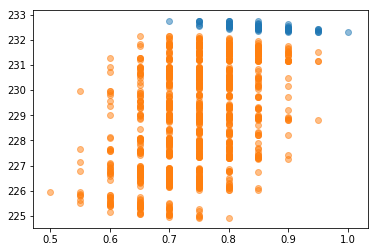

In [12]:
plt.scatter(support_sa, exact_risk, alpha = 0.5)
plt.scatter(isupport_sa, iexact_risk, alpha = 0.5)

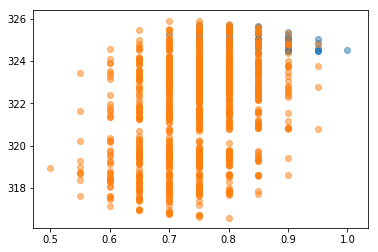

In [13]:
plt.scatter(support_sa, empirical_risk_test, alpha = 0.5)
plt.scatter(isupport_sa, iempirical_risk_test, alpha = 0.5)

### The results are clear - the ordinary risk leads to near-optimal results w.r.t selecting the smallest correct model,  but does not perform adequately when the incorrect models are included in the candidate model set. Can we design a penalized likelihood function that acts like an oracle for the true support? ###

In [14]:
# Assess the ordinary risk on all models
exact_penalized_risk = np.zeros(models.shape[0])
exact_penalized_risk_test = np.zeros(models.shape[0])

iexact_penalized_risk = np.zeros(imodels.shape[0])
iexact_penalized_risk_test = np.zeros(imodels.shape[0])

for i in range(models.shape[0]):
    sigma_hat = np.mean(np.linalg.norm(y - X @ models[i, :]))
    exact_penalized_risk[i] = risk.exact_penalized_KL(models[i, :], 50, 
                                            X @ models[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    
    sigma_hat = np.mean(np.linalg.norm(y_test - X_test @ models[i, :]))
    exact_penalized_risk_test[i] = risk.exact_penalized_KL(models[i, :], 50,
                                                X_test @ models[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    
for i in range(imodels.shape[0]):
    sigma_hat = np.mean(np.linalg.norm(y - X @ imodels[i, :]))
    iexact_penalized_risk[i] = risk.exact_penalized_KL(imodels[i, :], 50,
                                             X @ imodels[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    
    sigma_hat = np.mean(np.linalg.norm(y_test - X_test @ imodels[i, :]))
    iexact_penalized_risk_test[i] = risk.exact_penalized_KL(imodels[i, :], 50,
                                                  X_test @ imodels[i, :], np.sqrt(sigma_hat), np.sqrt(ss))

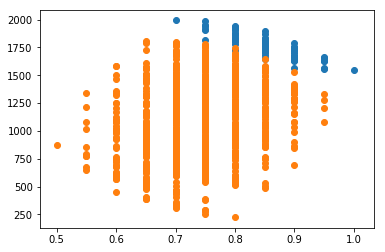

In [15]:
plt.scatter(support_sa, exact_penalized_risk)
plt.scatter(isupport_sa, iexact_penalized_risk)

### Instead of considering all possible subsets, use UoI to do feature selection

In [4]:
uoil = UoI_Lasso(fit_intercept = True, estimation_score = 'MIC')
uoil.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='MIC', fit_intercept=True, manual_penalty=2,
     max_iter=None, n_boots_est=48, n_boots_sel=48, n_lambdas=48,
     normalize=True,
     random_state=<module 'numpy.random' from 'C:\\Users\\akumar\\Anaconda3\\envs\\nse\\lib\\site-packages\\numpy\\random\\__init__.py'>,
     selection_frac=0.9, stability_selection=1.0, warm_start=None)

In [40]:
selection_accuracy(beta.ravel(), uoil.coef_)

array([1.])

In [41]:
selection_accuracy(beta.ravel(), uoil.alt_coef_)

array([0.8])

In [42]:
beta

array([[0.        ],
       [9.42352347],
       [0.        ],
       [5.52304636],
       [0.        ],
       [8.89290503],
       [0.        ],
       [0.        ],
       [6.19461442],
       [0.        ]])

In [43]:
uoil.alt_coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [44]:
uoil.supports_.shape

(11, 10)

In [19]:
# Fit OLS to the uoi supports 
uoi_models = np.zeros(uoil.supports_.shape)
for i in range(uoil.supports_.shape[0]):
    s = uoil.supports_[i, :]
    m, _, _, _ = scipy.linalg.lstsq(X[:, s], y)
    uoi_models[i, s] = m.ravel() 

In [20]:
# Assess the ordinary risk on uoi_models
uoi_exact_risk = np.zeros(uoi_models.shape[0])
uoi_exact_risk_test = np.zeros(uoi_models.shape[0])

uoi_empirical_risk = np.zeros(uoi_models.shape[0])
uoi_empirical_risk_test = np.zeros(uoi_models.shape[0])

uoi_MIC = np.zeros(uoi_models.shape[0])
uoi_MIC_test = np.zeros(uoi_models.shape[0])

for i in range(uoi_models.shape[0]):
    sigma_hat = np.mean(np.linalg.norm(y - X @ uoi_models[i, :]))
    uoi_exact_risk[i] = risk.calc_KL_div(X @ uoi_models[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    
    uoi_empirical_risk[i] = risk.empirical_KL_estimate(y, X @ uoi_models[i, :], np.sqrt(sigma_hat))
    uoi_MIC[i] = risk.MIC(y, X @ uoi_models[i, :], np.sqrt(sigma_hat), np.count_nonzero(uoi_models[i, :]), 2)
    
    sigma_hat = np.mean(np.linalg.norm(y_test - X_test @ uoi_models[i, :]))
    uoi_exact_risk_test[i] = risk.calc_KL_div(X_test @ uoi_models[i, :], np.sqrt(sigma_hat), np.sqrt(ss))
    uoi_empirical_risk_test[i] = risk.empirical_KL_estimate(y_test, X_test @ uoi_models[i, :], np.sqrt(sigma_hat))
    uoi_MIC_test[i] = risk.MIC(y_test, X_test @ uoi_models[i, :], np.sqrt(sigma_hat), np.count_nonzero(uoi_models[i, :]), 2)


In [21]:
uoi_sa = selection_accuracy(beta.ravel(), uoi_models)

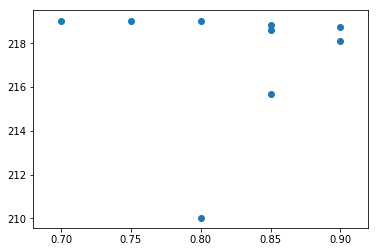

In [22]:
plt.scatter(uoi_sa, uoi_exact_risk)

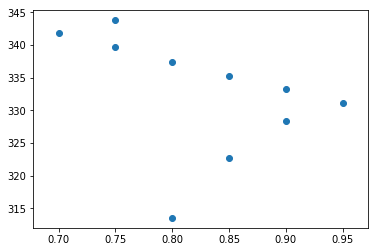

In [22]:
plt.scatter(uoi_sa, uoi_MIC)

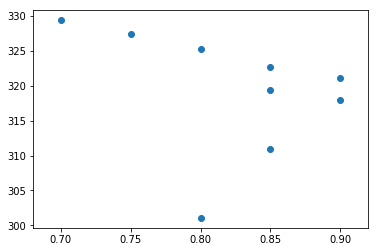

In [23]:
plt.scatter(uoi_sa, uoi_MIC_test)

### We are missing something here. Few things to try out  - how does AIC and other estimators (incl. MIC) behave differently to the picture above? Are we sure that our risk function is correct? Seems inappropriate to be pointing towarsd the null model. Then, there is the issue of the size of the test data set being 1/10 the size of the train data set. Does this play into it?

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [6]:
# Reproduce the situation above, but now fit the models on 90 % of the data and evaluate test scores on the remaining 10 %.

# Create bootstraps
n_boots = 48

boot_exact_risk = np.zeros((uoil.supports_.shape[0], n_boots))
boot_exact_risk_test = np.zeros((uoil.supports_.shape[0], n_boots))

boot_empirical_risk = np.zeros((uoil.supports_.shape[0], n_boots))
boot_empirical_risk_test = np.zeros((uoil.supports_.shape[0], n_boots))

boot_MIC = np.zeros((uoil.supports_.shape[0], n_boots))
boot_MIC_test = np.zeros((uoil.supports_.shape[0], n_boots))

boot_sa = np.zeros((uoil.supports_.shape[0], n_boots))

boot_models = np.zeros(((uoil.supports_.shape) + (n_boots,)))

for i in range(uoil.supports_.shape[0]):

    s = uoil.supports_[i, :]
    
    for boot in range(n_boots):
        
        # Bootstrap the data:
        train_idxs, test_idxs = train_test_split(np.arange(X.shape[0]),
                                                test_size = 0.1)
        X_b = X[train_idxs]
        X_t = X[test_idxs]
        y_b = y[train_idxs]
        y_t = y[test_idxs]
                

        m = np.zeros(n_features)
        
        if X_b[:, s].size > 0:
            # Fit OLS model
            mm = LinearRegression().fit(X_b[:, s], y_b)
            m[s] = mm.coef_.ravel()
            y_pred = mm.predict(X_b[:, s])
        else:
            y_pred = np.zeros(y_b.shape)
        
        # Calculate risks on bootstrap and test samples:
        sigma_hat = np.mean(np.linalg.norm(y_b - y_pred))
        boot_exact_risk[i, boot] = risk.calc_KL_div(y_pred, np.sqrt(sigma_hat), np.sqrt(ss))

        boot_empirical_risk[i, boot] = risk.empirical_KL_estimate(y_b, y_pred, np.sqrt(sigma_hat))
        boot_MIC[i, boot] = risk.MIC(y_b, y_pred, np.sqrt(sigma_hat), np.count_nonzero(m.ravel()), 2)

        sigma_hat = np.mean(np.linalg.norm(y_t - X_t @ m.ravel()))
        boot_exact_risk_test[i, boot] = risk.calc_KL_div(X_t @ m.ravel(), np.sqrt(sigma_hat), np.sqrt(ss))
        boot_empirical_risk_test[i, boot] = risk.empirical_KL_estimate(y_t, X_t @ m.ravel(), np.sqrt(sigma_hat))
        boot_MIC_test[i, boot] = risk.MIC(y_t, X_t @ m.ravel(), np.sqrt(sigma_hat), np.count_nonzero(m.ravel()), 2)

        boot_sa[i, boot] = selection_accuracy(beta.ravel(), m)

In [7]:
uoil.estimates_.shape

(48, 9, 10)

In [8]:
uoil_sa = np.zeros((uoil.estimates_.shape[0], uoil.estimates_.shape[1]))
for i in range(uoil.estimates_.shape[0]):
    for j in range(uoil.estimates_.shape[1]):
        uoil_sa[i, j] = selection_accuracy(beta.ravel(), uoil.estimates_[i, j, :])

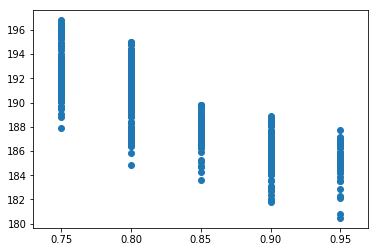

In [9]:
plt.scatter(boot_sa.ravel(), boot_MIC.ravel())

In [62]:
# What would be the equivalent of rp_max_idx_ for us?
rp_max_idx_ = np.argmin(boot_MIC, axis = 0)

In [63]:
rp_max_idx_

array([3, 2, 3, 1, 7, 1, 2, 1, 3, 3, 3, 2, 4, 6, 5, 3, 6, 3, 1, 1, 5, 2,
       5, 3, 2, 3, 5, 4, 7, 2, 7, 3, 4, 2, 3, 2, 3, 4, 6, 3, 3, 2, 5, 4,
       1, 6, 5, 4], dtype=int64)

In [9]:
uoil.rp_max_idx_

array([4, 4, 4, 6, 3, 4, 4, 3, 6, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 6, 4, 3,
       3, 3, 4, 3], dtype=int64)

In [11]:
uoil.alt_rp_max_idx_

array([2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 2,
       3, 2, 4, 2], dtype=int64)

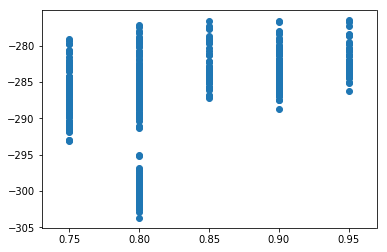

In [11]:
plt.scatter(uoil_sa.ravel(), uoil.scores_.ravel())

In [14]:
uoil.alt_rp_max_idx_

array([2, 2, 3, 2, 2, 2, 2, 5, 4, 2, 2, 2, 2, 5, 2, 2, 2, 2, 4, 2, 1, 2,
       2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 4, 3, 2, 2, 5, 2, 5, 2, 2, 2,
       2, 3, 5, 5], dtype=int64)

In [13]:
uoil.rp_max_idx_

array([2, 2, 3, 2, 2, 2, 2, 5, 4, 2, 2, 2, 2, 5, 2, 2, 2, 2, 4, 2, 1, 2,
       2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 4, 3, 2, 2, 5, 2, 5, 2, 2, 2,
       2, 3, 5, 5], dtype=int64)

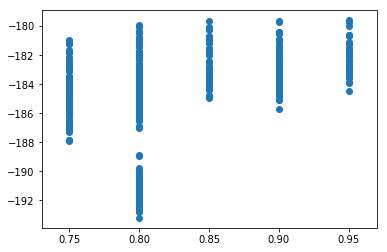

In [12]:
plt.scatter(uoil_sa.ravel(), uoil.alt_scores_.ravel())

In [ ]:
# Ensure that the ordering of models suggested by our method corresponds to the ordering of models suggested by UoI's AIC/MIC

### Really do cross-validation as opposed to this single fold

### Get at the asymptotics, just to make sure we understand what is going on --> even if it isn't necessarily useful

In [ ]:
# First thing to do - MIC on the train data with a much wider range of penalties. Does this lead to good performance?

In [ ]:
# Is the goal of good support recovery well-aligned with risk minimization?